In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.75,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_075_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:32 - loss: 0.1938 - STD: 1.5258e-04 - MAE: 0.4295

 4/74 [>.............................] - ETA: 2s - loss: 0.0651 - STD: 3.9893e-04 - MAE: 0.1962  

 5/74 [=>............................] - ETA: 2s - loss: 0.0560 - STD: 3.5421e-04 - MAE: 0.1786

 6/74 [=>............................] - ETA: 2s - loss: 0.0506 - STD: 3.1243e-04 - MAE: 0.1693

 7/74 [=>............................] - ETA: 3s - loss: 0.0472 - STD: 2.7738e-04 - MAE: 0.1642

 8/74 [==>...........................] - ETA: 3s - loss: 0.0449 - STD: 2.4798e-04 - MAE: 0.1612

 9/74 [==>...........................] - ETA: 3s - loss: 0.0432 - STD: 2.2347e-04 - MAE: 0.1591

10/74 [===>..........................] - ETA: 3s - loss: 0.0419 - STD: 2.0288e-04 - MAE: 0.1577

11/74 [===>..........................] - ETA: 3s - loss: 0.0408 - STD: 1.8540e-04 - MAE: 0.1565

12/74 [===>..........................] - ETA: 3s - loss: 0.0398 - STD: 1.7049e-04 - MAE: 0.1554

13/74 [====>.........................] - ETA: 3s - loss: 0.0390 - STD: 1.5797e-04 - MAE: 0.1543

14/74 [====>.........................] - ETA: 3s - loss: 0.0382 - STD: 1.4745e-04 - MAE: 0.1532

15/74 [=====>........................] - ETA: 3s - loss: 0.0375 - STD: 1.3858e-04 - MAE: 0.1520

16/74 [=====>........................] - ETA: 3s - loss: 0.0368 - STD: 1.3102e-04 - MAE: 0.1507

17/74 [=====>........................] - ETA: 3s - loss: 0.0361 - STD: 1.2456e-04 - MAE: 0.1491

18/74 [======>.......................] - ETA: 3s - loss: 0.0353 - STD: 1.1893e-04 - MAE: 0.1473

19/74 [======>.......................] - ETA: 3s - loss: 0.0345 - STD: 1.1406e-04 - MAE: 0.1454

20/74 [=======>......................] - ETA: 3s - loss: 0.0337 - STD: 1.0987e-04 - MAE: 0.1431

21/74 [=======>......................] - ETA: 3s - loss: 0.0328 - STD: 1.0622e-04 - MAE: 0.1407

22/74 [=======>......................] - ETA: 3s - loss: 0.0319 - STD: 1.0291e-04 - MAE: 0.1381

23/74 [========>.....................] - ETA: 3s - loss: 0.0310 - STD: 9.9882e-05 - MAE: 0.1355

24/74 [========>.....................] - ETA: 3s - loss: 0.0302 - STD: 9.7118e-05 - MAE: 0.1330

25/74 [=========>....................] - ETA: 3s - loss: 0.0293 - STD: 9.4496e-05 - MAE: 0.1306

26/74 [=========>....................] - ETA: 2s - loss: 0.0286 - STD: 9.2054e-05 - MAE: 0.1286

27/74 [=========>....................] - ETA: 2s - loss: 0.0279 - STD: 8.9819e-05 - MAE: 0.1268

28/74 [==========>...................] - ETA: 2s - loss: 0.0272 - STD: 8.7696e-05 - MAE: 0.1253

29/74 [==========>...................] - ETA: 2s - loss: 0.0267 - STD: 8.5717e-05 - MAE: 0.1241

30/74 [===========>..................] - ETA: 2s - loss: 0.0262 - STD: 8.3713e-05 - MAE: 0.1231

31/74 [===========>..................] - ETA: 2s - loss: 0.0258 - STD: 8.1763e-05 - MAE: 0.1222

32/74 [===========>..................] - ETA: 2s - loss: 0.0253 - STD: 7.9811e-05 - MAE: 0.1213

33/74 [============>.................] - ETA: 2s - loss: 0.0249 - STD: 7.7923e-05 - MAE: 0.1204

34/74 [============>.................] - ETA: 2s - loss: 0.0245 - STD: 7.6099e-05 - MAE: 0.1195

35/74 [=============>................] - ETA: 2s - loss: 0.0241 - STD: 7.4356e-05 - MAE: 0.1185

36/74 [=============>................] - ETA: 2s - loss: 0.0237 - STD: 7.2567e-05 - MAE: 0.1174

37/74 [==============>...............] - ETA: 2s - loss: 0.0233 - STD: 7.0866e-05 - MAE: 0.1163

38/74 [==============>...............] - ETA: 2s - loss: 0.0230 - STD: 6.9241e-05 - MAE: 0.1153

39/74 [==============>...............] - ETA: 2s - loss: 0.0226 - STD: 6.7689e-05 - MAE: 0.1142

40/74 [===============>..............] - ETA: 2s - loss: 0.0223 - STD: 6.6181e-05 - MAE: 0.1132

41/74 [===============>..............] - ETA: 2s - loss: 0.0220 - STD: 6.4736e-05 - MAE: 0.1122

42/74 [================>.............] - ETA: 2s - loss: 0.0217 - STD: 6.3370e-05 - MAE: 0.1114

43/74 [================>.............] - ETA: 1s - loss: 0.0214 - STD: 6.2094e-05 - MAE: 0.1105

44/74 [================>.............] - ETA: 1s - loss: 0.0211 - STD: 6.0813e-05 - MAE: 0.1096

45/74 [=================>............] - ETA: 1s - loss: 0.0209 - STD: 5.9602e-05 - MAE: 0.1089

46/74 [=================>............] - ETA: 1s - loss: 0.0207 - STD: 5.8470e-05 - MAE: 0.1081

47/74 [==================>...........] - ETA: 1s - loss: 0.0204 - STD: 5.7440e-05 - MAE: 0.1074

48/74 [==================>...........] - ETA: 1s - loss: 0.0203 - STD: 5.6402e-05 - MAE: 0.1067

52/74 [====================>.........] - ETA: 1s - loss: 0.0195 - STD: 5.2722e-05 - MAE: 0.1042

53/74 [====================>.........] - ETA: 1s - loss: 0.0193 - STD: 5.1887e-05 - MAE: 0.1036

54/74 [====================>.........] - ETA: 1s - loss: 0.0191 - STD: 5.1101e-05 - MAE: 0.1032

55/74 [=====================>........] - ETA: 1s - loss: 0.0189 - STD: 5.0340e-05 - MAE: 0.1027

56/74 [=====================>........] - ETA: 1s - loss: 0.0187 - STD: 4.9622e-05 - MAE: 0.1022

57/74 [======================>.......] - ETA: 1s - loss: 0.0186 - STD: 4.8933e-05 - MAE: 0.1018

58/74 [======================>.......] - ETA: 1s - loss: 0.0184 - STD: 4.8260e-05 - MAE: 0.1014

59/74 [======================>.......] - ETA: 1s - loss: 0.0183 - STD: 4.7585e-05 - MAE: 0.1010

60/74 [=======================>......] - ETA: 0s - loss: 0.0181 - STD: 4.6971e-05 - MAE: 0.1006

61/74 [=======================>......] - ETA: 0s - loss: 0.0180 - STD: 4.6379e-05 - MAE: 0.1002

62/74 [========================>.....] - ETA: 0s - loss: 0.0178 - STD: 4.5756e-05 - MAE: 0.0999

63/74 [========================>.....] - ETA: 0s - loss: 0.0177 - STD: 4.5192e-05 - MAE: 0.0995

64/74 [========================>.....] - ETA: 0s - loss: 0.0175 - STD: 4.4643e-05 - MAE: 0.0991

65/74 [=========================>....] - ETA: 0s - loss: 0.0174 - STD: 4.4110e-05 - MAE: 0.0987

66/74 [=========================>....] - ETA: 0s - loss: 0.0173 - STD: 4.3603e-05 - MAE: 0.0984

67/74 [==========================>...] - ETA: 0s - loss: 0.0172 - STD: 4.3121e-05 - MAE: 0.0980

68/74 [==========================>...] - ETA: 0s - loss: 0.0170 - STD: 4.2656e-05 - MAE: 0.0977

69/74 [==========================>...] - ETA: 0s - loss: 0.0169 - STD: 4.2212e-05 - MAE: 0.0973

70/74 [===========================>..] - ETA: 0s - loss: 0.0168 - STD: 4.1775e-05 - MAE: 0.0970

71/74 [===========================>..] - ETA: 0s - loss: 0.0167 - STD: 4.1350e-05 - MAE: 0.0967

72/74 [============================>.] - ETA: 0s - loss: 0.0166 - STD: 4.0954e-05 - MAE: 0.0964

73/74 [============================>.] - ETA: 0s - loss: 0.0165 - STD: 4.0567e-05 - MAE: 0.0961

74/74 [==============================] - ETA: 0s - loss: 0.0164 - STD: 4.0172e-05 - MAE: 0.0958

74/74 [==============================] - 7s 79ms/step - loss: 0.0164 - STD: 4.0172e-05 - MAE: 0.0958 - val_loss: 0.0086 - val_STD: 7.6649e-06 - val_MAE: 0.0712


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0090 - STD: 1.0960e-05 - MAE: 0.0740

 2/74 [..............................] - ETA: 5s - loss: 0.0090 - STD: 1.1576e-05 - MAE: 0.0743

 3/74 [>.............................] - ETA: 4s - loss: 0.0090 - STD: 1.1803e-05 - MAE: 0.0744

 4/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 1.1958e-05 - MAE: 0.0748

 5/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 1.1904e-05 - MAE: 0.0750

 6/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 1.1760e-05 - MAE: 0.0751

 7/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.1688e-05 - MAE: 0.0754

 8/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.1690e-05 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.1722e-05 - MAE: 0.0756

10/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 1.1803e-05 - MAE: 0.0756

11/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 1.1894e-05 - MAE: 0.0755

12/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 1.2003e-05 - MAE: 0.0755

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.2134e-05 - MAE: 0.0756

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.2270e-05 - MAE: 0.0756

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.2404e-05 - MAE: 0.0756

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.2580e-05 - MAE: 0.0756

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.2752e-05 - MAE: 0.0756

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.2903e-05 - MAE: 0.0756

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.3077e-05 - MAE: 0.0756

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.3256e-05 - MAE: 0.0755

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.3435e-05 - MAE: 0.0755

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.3619e-05 - MAE: 0.0755

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.3782e-05 - MAE: 0.0755

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.3903e-05 - MAE: 0.0755

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.4007e-05 - MAE: 0.0754

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.4070e-05 - MAE: 0.0754

27/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 1.4170e-05 - MAE: 0.0754

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 1.4285e-05 - MAE: 0.0754

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.4430e-05 - MAE: 0.0754

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.4614e-05 - MAE: 0.0754

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.4821e-05 - MAE: 0.0755

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.5025e-05 - MAE: 0.0755

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.5228e-05 - MAE: 0.0755

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.5426e-05 - MAE: 0.0755

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.5560e-05 - MAE: 0.0755

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.5685e-05 - MAE: 0.0755

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.5808e-05 - MAE: 0.0754

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.5929e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.6067e-05 - MAE: 0.0755

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.6206e-05 - MAE: 0.0754

41/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.6350e-05 - MAE: 0.0754

42/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 1.6500e-05 - MAE: 0.0754

43/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 1.6652e-05 - MAE: 0.0754

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.6807e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.6946e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.7089e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.7278e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.7467e-05 - MAE: 0.0754

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.7648e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.7823e-05 - MAE: 0.0754

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.8005e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.8187e-05 - MAE: 0.0754

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.8373e-05 - MAE: 0.0754

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.8550e-05 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.8733e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.8904e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 1.9092e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 1.9293e-05 - MAE: 0.0755

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.9492e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.9708e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.9932e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.0354e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 2.0562e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.0773e-05 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 2.0993e-05 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.1197e-05 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.1406e-05 - MAE: 0.0754

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 2.1644e-05 - MAE: 0.0754

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.1902e-05 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 2.2165e-05 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.2443e-05 - MAE: 0.0755

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 2.2717e-05 - MAE: 0.0755

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 2.2995e-05 - MAE: 0.0754

74/74 [==============================] - 5s 69ms/step - loss: 0.0092 - STD: 2.2995e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 2.8268e-05 - val_MAE: 0.0718


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0091 - STD: 4.3413e-05 - MAE: 0.0755

 2/74 [..............................] - ETA: 5s - loss: 0.0092 - STD: 4.3871e-05 - MAE: 0.0762

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 4.4139e-05 - MAE: 0.0759

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 4.4569e-05 - MAE: 0.0759

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 4.5140e-05 - MAE: 0.0757

 6/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 4.5660e-05 - MAE: 0.0757

 7/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 4.6247e-05 - MAE: 0.0757

 8/74 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 4.6784e-05 - MAE: 0.0756

 9/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 4.7269e-05 - MAE: 0.0754

10/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.7793e-05 - MAE: 0.0754

11/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.8186e-05 - MAE: 0.0753

12/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 4.8650e-05 - MAE: 0.0754

13/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 4.9117e-05 - MAE: 0.0754

14/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 4.9602e-05 - MAE: 0.0755

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 5.0155e-05 - MAE: 0.0755

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 5.0725e-05 - MAE: 0.0755

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 5.1331e-05 - MAE: 0.0755

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.1913e-05 - MAE: 0.0754

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 5.2443e-05 - MAE: 0.0754

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.2981e-05 - MAE: 0.0754

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.3557e-05 - MAE: 0.0754

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 5.4164e-05 - MAE: 0.0754

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 5.5438e-05 - MAE: 0.0755

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.6096e-05 - MAE: 0.0755

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.6770e-05 - MAE: 0.0755

27/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 5.7449e-05 - MAE: 0.0755

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 5.8144e-05 - MAE: 0.0755

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 5.8862e-05 - MAE: 0.0755

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 5.9606e-05 - MAE: 0.0755

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.0368e-05 - MAE: 0.0755

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 6.1120e-05 - MAE: 0.0755

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.1899e-05 - MAE: 0.0755

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 6.2674e-05 - MAE: 0.0755

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 6.3474e-05 - MAE: 0.0755

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 6.4306e-05 - MAE: 0.0755

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 6.5147e-05 - MAE: 0.0755

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 6.6057e-05 - MAE: 0.0754

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 6.6955e-05 - MAE: 0.0755

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 6.7862e-05 - MAE: 0.0755

41/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 6.8825e-05 - MAE: 0.0755

42/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 6.9766e-05 - MAE: 0.0754

43/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 7.0706e-05 - MAE: 0.0754

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.1716e-05 - MAE: 0.0754

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 7.2732e-05 - MAE: 0.0754

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 7.3802e-05 - MAE: 0.0754

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 7.4913e-05 - MAE: 0.0754

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 7.6036e-05 - MAE: 0.0755

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 7.7214e-05 - MAE: 0.0754

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 7.8436e-05 - MAE: 0.0754

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 7.9709e-05 - MAE: 0.0754

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.0982e-05 - MAE: 0.0754

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.2297e-05 - MAE: 0.0754

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.3622e-05 - MAE: 0.0754

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 8.4973e-05 - MAE: 0.0754

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 8.6329e-05 - MAE: 0.0754

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 8.7743e-05 - MAE: 0.0754

58/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 8.9181e-05 - MAE: 0.0754

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 9.0685e-05 - MAE: 0.0754

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 9.2200e-05 - MAE: 0.0754

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 9.3782e-05 - MAE: 0.0754

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.5391e-05 - MAE: 0.0754

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.7041e-05 - MAE: 0.0754

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.8717e-05 - MAE: 0.0754

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.0048e-04 - MAE: 0.0754

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.0227e-04 - MAE: 0.0754

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0413e-04 - MAE: 0.0754

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0606e-04 - MAE: 0.0753

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.0804e-04 - MAE: 0.0753

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.1007e-04 - MAE: 0.0754

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.1213e-04 - MAE: 0.0754

72/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.1425e-04 - MAE: 0.0754

73/74 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.1640e-04 - MAE: 0.0754

74/74 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.1867e-04 - MAE: 0.0754

74/74 [==============================] - 5s 70ms/step - loss: 0.0092 - STD: 1.1867e-04 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.8879e-04 - val_MAE: 0.0715


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0092 - STD: 2.9303e-04 - MAE: 0.0754

 2/74 [..............................] - ETA: 4s - loss: 0.0092 - STD: 2.9773e-04 - MAE: 0.0755

 3/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 3.0163e-04 - MAE: 0.0756

 4/74 [>.............................] - ETA: 4s - loss: 0.0093 - STD: 3.0627e-04 - MAE: 0.0756

 5/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 3.1030e-04 - MAE: 0.0756

 6/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 3.1527e-04 - MAE: 0.0757

 7/74 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 3.2079e-04 - MAE: 0.0758

 8/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 3.2585e-04 - MAE: 0.0756

 9/74 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 3.3104e-04 - MAE: 0.0753

10/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 3.3609e-04 - MAE: 0.0753

11/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 3.4147e-04 - MAE: 0.0753

12/74 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 3.4694e-04 - MAE: 0.0753

13/74 [====>.........................] - ETA: 4s - loss: 0.0092 - STD: 3.5255e-04 - MAE: 0.0754

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.6495e-04 - MAE: 0.0754

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.7126e-04 - MAE: 0.0754

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 3.7774e-04 - MAE: 0.0754

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 3.8431e-04 - MAE: 0.0754

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 3.9103e-04 - MAE: 0.0754

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 3.9772e-04 - MAE: 0.0754

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 4.0503e-04 - MAE: 0.0754

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 4.1243e-04 - MAE: 0.0753

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 4.2012e-04 - MAE: 0.0753

24/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 4.2815e-04 - MAE: 0.0753

25/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 4.3645e-04 - MAE: 0.0753

26/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 4.4463e-04 - MAE: 0.0753

27/74 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 4.5315e-04 - MAE: 0.0753

28/74 [==========>...................] - ETA: 3s - loss: 0.0092 - STD: 4.6198e-04 - MAE: 0.0752

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 4.7134e-04 - MAE: 0.0753

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.8105e-04 - MAE: 0.0753

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.9106e-04 - MAE: 0.0753

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 5.0119e-04 - MAE: 0.0753

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 5.1192e-04 - MAE: 0.0753

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 5.2267e-04 - MAE: 0.0753

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 5.3376e-04 - MAE: 0.0753

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 5.4535e-04 - MAE: 0.0753

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.5719e-04 - MAE: 0.0753

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.6939e-04 - MAE: 0.0753

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 5.8215e-04 - MAE: 0.0752

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 5.9538e-04 - MAE: 0.0752

41/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 6.0901e-04 - MAE: 0.0752

42/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 6.2311e-04 - MAE: 0.0752

43/74 [================>.............] - ETA: 2s - loss: 0.0092 - STD: 6.3719e-04 - MAE: 0.0751

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 6.5247e-04 - MAE: 0.0751

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 6.6783e-04 - MAE: 0.0751

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 6.8424e-04 - MAE: 0.0751

47/74 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 7.0078e-04 - MAE: 0.0751

48/74 [==================>...........] - ETA: 1s - loss: 0.0091 - STD: 7.1823e-04 - MAE: 0.0751

49/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 7.3629e-04 - MAE: 0.0752

50/74 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 7.5510e-04 - MAE: 0.0751

51/74 [===================>..........] - ETA: 1s - loss: 0.0091 - STD: 7.7452e-04 - MAE: 0.0751

52/74 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 7.9464e-04 - MAE: 0.0751

53/74 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 8.1555e-04 - MAE: 0.0751

54/74 [====================>.........] - ETA: 1s - loss: 0.0091 - STD: 8.3712e-04 - MAE: 0.0751

55/74 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 8.5972e-04 - MAE: 0.0751

56/74 [=====================>........] - ETA: 1s - loss: 0.0091 - STD: 8.8286e-04 - MAE: 0.0751

57/74 [======================>.......] - ETA: 1s - loss: 0.0091 - STD: 9.0712e-04 - MAE: 0.0751

58/74 [======================>.......] - ETA: 1s - loss: 0.0091 - STD: 9.3248e-04 - MAE: 0.0751

59/74 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 9.5896e-04 - MAE: 0.0751

60/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 9.8622e-04 - MAE: 0.0751

61/74 [=======================>......] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751    

62/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0010 - MAE: 0.0751

63/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

64/74 [========================>.....] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

65/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0751

66/74 [=========================>....] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0751

67/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

68/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0750

69/74 [==========================>...] - ETA: 0s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0750

70/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0013 - MAE: 0.0750

71/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0750

72/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0750

73/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

74/74 [==============================] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0749

74/74 [==============================] - 5s 70ms/step - loss: 0.0091 - STD: 0.0015 - MAE: 0.0749 - val_loss: 0.0082 - val_STD: 0.0034 - val_MAE: 0.0699


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0091 - STD: 0.0053 - MAE: 0.0747

 2/74 [..............................] - ETA: 4s - loss: 0.0089 - STD: 0.0054 - MAE: 0.0741

 3/74 [>.............................] - ETA: 4s - loss: 0.0088 - STD: 0.0055 - MAE: 0.0738

 4/74 [>.............................] - ETA: 4s - loss: 0.0088 - STD: 0.0056 - MAE: 0.0738

 5/74 [=>............................] - ETA: 4s - loss: 0.0088 - STD: 0.0058 - MAE: 0.0738

 6/74 [=>............................] - ETA: 4s - loss: 0.0088 - STD: 0.0059 - MAE: 0.0736

 7/74 [=>............................] - ETA: 4s - loss: 0.0088 - STD: 0.0061 - MAE: 0.0735

 8/74 [==>...........................] - ETA: 4s - loss: 0.0087 - STD: 0.0062 - MAE: 0.0733

 9/74 [==>...........................] - ETA: 4s - loss: 0.0087 - STD: 0.0064 - MAE: 0.0734

10/74 [===>..........................] - ETA: 4s - loss: 0.0087 - STD: 0.0066 - MAE: 0.0733

11/74 [===>..........................] - ETA: 4s - loss: 0.0087 - STD: 0.0067 - MAE: 0.0733

12/74 [===>..........................] - ETA: 4s - loss: 0.0087 - STD: 0.0069 - MAE: 0.0733

13/74 [====>.........................] - ETA: 4s - loss: 0.0087 - STD: 0.0071 - MAE: 0.0733

14/74 [====>.........................] - ETA: 3s - loss: 0.0086 - STD: 0.0073 - MAE: 0.0731

15/74 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0075 - MAE: 0.0730

16/74 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0077 - MAE: 0.0729

17/74 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0079 - MAE: 0.0728

18/74 [======>.......................] - ETA: 3s - loss: 0.0085 - STD: 0.0081 - MAE: 0.0727

19/74 [======>.......................] - ETA: 3s - loss: 0.0085 - STD: 0.0084 - MAE: 0.0726

20/74 [=======>......................] - ETA: 3s - loss: 0.0085 - STD: 0.0086 - MAE: 0.0726

21/74 [=======>......................] - ETA: 3s - loss: 0.0085 - STD: 0.0088 - MAE: 0.0725

22/74 [=======>......................] - ETA: 3s - loss: 0.0085 - STD: 0.0091 - MAE: 0.0725

23/74 [========>.....................] - ETA: 3s - loss: 0.0085 - STD: 0.0093 - MAE: 0.0724

24/74 [========>.....................] - ETA: 3s - loss: 0.0084 - STD: 0.0096 - MAE: 0.0723

25/74 [=========>....................] - ETA: 3s - loss: 0.0084 - STD: 0.0098 - MAE: 0.0723

26/74 [=========>....................] - ETA: 3s - loss: 0.0084 - STD: 0.0101 - MAE: 0.0722

27/74 [=========>....................] - ETA: 3s - loss: 0.0084 - STD: 0.0104 - MAE: 0.0722

28/74 [==========>...................] - ETA: 3s - loss: 0.0084 - STD: 0.0107 - MAE: 0.0721

29/74 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.0110 - MAE: 0.0721

30/74 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.0113 - MAE: 0.0720

31/74 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.0116 - MAE: 0.0719

32/74 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.0119 - MAE: 0.0718

33/74 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.0123 - MAE: 0.0718

34/74 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.0126 - MAE: 0.0717

35/74 [=============>................] - ETA: 2s - loss: 0.0083 - STD: 0.0129 - MAE: 0.0716

36/74 [=============>................] - ETA: 2s - loss: 0.0083 - STD: 0.0133 - MAE: 0.0715

37/74 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0136 - MAE: 0.0715

38/74 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0140 - MAE: 0.0714

39/74 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0143 - MAE: 0.0713

40/74 [===============>..............] - ETA: 2s - loss: 0.0082 - STD: 0.0147 - MAE: 0.0712

41/74 [===============>..............] - ETA: 2s - loss: 0.0082 - STD: 0.0150 - MAE: 0.0711

42/74 [================>.............] - ETA: 2s - loss: 0.0081 - STD: 0.0154 - MAE: 0.0710

43/74 [================>.............] - ETA: 2s - loss: 0.0081 - STD: 0.0158 - MAE: 0.0709

44/74 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0161 - MAE: 0.0709

45/74 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0165 - MAE: 0.0708

46/74 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0168 - MAE: 0.0707

47/74 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0172 - MAE: 0.0706

48/74 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0176 - MAE: 0.0705

49/74 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0179 - MAE: 0.0704

50/74 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.0183 - MAE: 0.0703

51/74 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.0187 - MAE: 0.0702

52/74 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0190 - MAE: 0.0701

53/74 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0194 - MAE: 0.0701

54/74 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0197 - MAE: 0.0699

55/74 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0201 - MAE: 0.0699

56/74 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0204 - MAE: 0.0698

57/74 [======================>.......] - ETA: 1s - loss: 0.0078 - STD: 0.0208 - MAE: 0.0697

58/74 [======================>.......] - ETA: 1s - loss: 0.0078 - STD: 0.0211 - MAE: 0.0696

59/74 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.0214 - MAE: 0.0695

60/74 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0217 - MAE: 0.0694

61/74 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0221 - MAE: 0.0693

62/74 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0224 - MAE: 0.0691

63/74 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0227 - MAE: 0.0690

64/74 [========================>.....] - ETA: 0s - loss: 0.0077 - STD: 0.0230 - MAE: 0.0690

65/74 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0233 - MAE: 0.0689

66/74 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0237 - MAE: 0.0688

68/74 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0243 - MAE: 0.0686

69/74 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0246 - MAE: 0.0685

70/74 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0249 - MAE: 0.0684

71/74 [===========================>..] - ETA: 0s - loss: 0.0076 - STD: 0.0252 - MAE: 0.0683

72/74 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0256 - MAE: 0.0682

73/74 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0259 - MAE: 0.0682

74/74 [==============================] - ETA: 0s - loss: 0.0075 - STD: 0.0262 - MAE: 0.0681

74/74 [==============================] - 5s 69ms/step - loss: 0.0075 - STD: 0.0262 - MAE: 0.0681 - val_loss: 0.0053 - val_STD: 0.0353 - val_MAE: 0.0554


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0062 - STD: 0.0487 - MAE: 0.0607

 2/74 [..............................] - ETA: 5s - loss: 0.0063 - STD: 0.0492 - MAE: 0.0611

 3/74 [>.............................] - ETA: 5s - loss: 0.0063 - STD: 0.0493 - MAE: 0.0616

 4/74 [>.............................] - ETA: 4s - loss: 0.0063 - STD: 0.0492 - MAE: 0.0614

 5/74 [=>............................] - ETA: 4s - loss: 0.0062 - STD: 0.0492 - MAE: 0.0611

 6/74 [=>............................] - ETA: 4s - loss: 0.0062 - STD: 0.0493 - MAE: 0.0609

 7/74 [=>............................] - ETA: 4s - loss: 0.0062 - STD: 0.0495 - MAE: 0.0610

 8/74 [==>...........................] - ETA: 4s - loss: 0.0061 - STD: 0.0496 - MAE: 0.0608

 9/74 [==>...........................] - ETA: 4s - loss: 0.0061 - STD: 0.0496 - MAE: 0.0607

10/74 [===>..........................] - ETA: 4s - loss: 0.0061 - STD: 0.0496 - MAE: 0.0605

11/74 [===>..........................] - ETA: 4s - loss: 0.0061 - STD: 0.0496 - MAE: 0.0605

12/74 [===>..........................] - ETA: 4s - loss: 0.0061 - STD: 0.0497 - MAE: 0.0605

13/74 [====>.........................] - ETA: 4s - loss: 0.0061 - STD: 0.0497 - MAE: 0.0603

14/74 [====>.........................] - ETA: 4s - loss: 0.0060 - STD: 0.0498 - MAE: 0.0602

15/74 [=====>........................] - ETA: 4s - loss: 0.0060 - STD: 0.0499 - MAE: 0.0601

16/74 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0500 - MAE: 0.0600

17/74 [=====>........................] - ETA: 3s - loss: 0.0060 - STD: 0.0501 - MAE: 0.0600

18/74 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.0504 - MAE: 0.0600

19/74 [======>.......................] - ETA: 3s - loss: 0.0060 - STD: 0.0505 - MAE: 0.0599

20/74 [=======>......................] - ETA: 3s - loss: 0.0060 - STD: 0.0505 - MAE: 0.0598

21/74 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0508 - MAE: 0.0597

22/74 [=======>......................] - ETA: 3s - loss: 0.0059 - STD: 0.0509 - MAE: 0.0596

24/74 [========>.....................] - ETA: 3s - loss: 0.0059 - STD: 0.0511 - MAE: 0.0595

25/74 [=========>....................] - ETA: 3s - loss: 0.0059 - STD: 0.0512 - MAE: 0.0594

26/74 [=========>....................] - ETA: 3s - loss: 0.0059 - STD: 0.0512 - MAE: 0.0593

27/74 [=========>....................] - ETA: 3s - loss: 0.0059 - STD: 0.0514 - MAE: 0.0593

28/74 [==========>...................] - ETA: 3s - loss: 0.0059 - STD: 0.0515 - MAE: 0.0592

29/74 [==========>...................] - ETA: 2s - loss: 0.0059 - STD: 0.0515 - MAE: 0.0591

30/74 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0517 - MAE: 0.0591

31/74 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0518 - MAE: 0.0590

32/74 [===========>..................] - ETA: 2s - loss: 0.0058 - STD: 0.0519 - MAE: 0.0589

33/74 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0520 - MAE: 0.0589

34/74 [============>.................] - ETA: 2s - loss: 0.0058 - STD: 0.0521 - MAE: 0.0588

35/74 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0523 - MAE: 0.0587

36/74 [=============>................] - ETA: 2s - loss: 0.0058 - STD: 0.0524 - MAE: 0.0587

37/74 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0525 - MAE: 0.0586

38/74 [==============>...............] - ETA: 2s - loss: 0.0058 - STD: 0.0527 - MAE: 0.0586

39/74 [==============>...............] - ETA: 2s - loss: 0.0057 - STD: 0.0528 - MAE: 0.0585

40/74 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.0529 - MAE: 0.0585

41/74 [===============>..............] - ETA: 2s - loss: 0.0057 - STD: 0.0530 - MAE: 0.0584

42/74 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.0531 - MAE: 0.0584

43/74 [================>.............] - ETA: 2s - loss: 0.0057 - STD: 0.0532 - MAE: 0.0583

44/74 [================>.............] - ETA: 1s - loss: 0.0057 - STD: 0.0533 - MAE: 0.0583

45/74 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0534 - MAE: 0.0582

46/74 [=================>............] - ETA: 1s - loss: 0.0057 - STD: 0.0535 - MAE: 0.0582

47/74 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0535 - MAE: 0.0582

48/74 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0536 - MAE: 0.0581

49/74 [==================>...........] - ETA: 1s - loss: 0.0057 - STD: 0.0537 - MAE: 0.0581

50/74 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0538 - MAE: 0.0580

51/74 [===================>..........] - ETA: 1s - loss: 0.0057 - STD: 0.0538 - MAE: 0.0580

52/74 [====================>.........] - ETA: 1s - loss: 0.0057 - STD: 0.0539 - MAE: 0.0580

53/74 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0540 - MAE: 0.0579

54/74 [====================>.........] - ETA: 1s - loss: 0.0056 - STD: 0.0540 - MAE: 0.0579

55/74 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0542 - MAE: 0.0579

56/74 [=====================>........] - ETA: 1s - loss: 0.0056 - STD: 0.0542 - MAE: 0.0579

57/74 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0543 - MAE: 0.0578

58/74 [======================>.......] - ETA: 1s - loss: 0.0056 - STD: 0.0544 - MAE: 0.0578

59/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0545 - MAE: 0.0578

60/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0545 - MAE: 0.0577

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0546 - MAE: 0.0577

62/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0547 - MAE: 0.0577

63/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0548 - MAE: 0.0576

64/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0549 - MAE: 0.0576

65/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0549 - MAE: 0.0575

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0550 - MAE: 0.0575

67/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0551 - MAE: 0.0575

68/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0552 - MAE: 0.0575

69/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0552 - MAE: 0.0574

70/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0553 - MAE: 0.0574

71/74 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0574

72/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0574

73/74 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0555 - MAE: 0.0573

74/74 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0555 - MAE: 0.0573

74/74 [==============================] - 5s 70ms/step - loss: 0.0055 - STD: 0.0555 - MAE: 0.0573 - val_loss: 0.0045 - val_STD: 0.0493 - val_MAE: 0.0519


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0051 - STD: 0.0613 - MAE: 0.0556

 2/74 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0617 - MAE: 0.0559

 3/74 [>.............................] - ETA: 4s - loss: 0.0053 - STD: 0.0596 - MAE: 0.0555

 4/74 [>.............................] - ETA: 4s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0555

 5/74 [=>............................] - ETA: 4s - loss: 0.0052 - STD: 0.0604 - MAE: 0.0556

 7/74 [=>............................] - ETA: 3s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0551

 8/74 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.0603 - MAE: 0.0554

 9/74 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.0598 - MAE: 0.0553

10/74 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0551

11/74 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0552

12/74 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0552

13/74 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0598 - MAE: 0.0551

14/74 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0552

15/74 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0552

16/74 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0599 - MAE: 0.0551

17/74 [=====>........................] - ETA: 3s - loss: 0.0052 - STD: 0.0600 - MAE: 0.0551

18/74 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0551

19/74 [======>.......................] - ETA: 3s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0551

20/74 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0550

21/74 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0602 - MAE: 0.0550

22/74 [=======>......................] - ETA: 3s - loss: 0.0052 - STD: 0.0602 - MAE: 0.0550

23/74 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0602 - MAE: 0.0550

24/74 [========>.....................] - ETA: 3s - loss: 0.0052 - STD: 0.0603 - MAE: 0.0550

25/74 [=========>....................] - ETA: 3s - loss: 0.0052 - STD: 0.0604 - MAE: 0.0550

26/74 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0549

27/74 [=========>....................] - ETA: 3s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0549

28/74 [==========>...................] - ETA: 3s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0548

29/74 [==========>...................] - ETA: 2s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0548

30/74 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0606 - MAE: 0.0548

31/74 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0548

32/74 [===========>..................] - ETA: 2s - loss: 0.0051 - STD: 0.0607 - MAE: 0.0548

33/74 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0547

34/74 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0547

35/74 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0547

36/74 [=============>................] - ETA: 2s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0546

37/74 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0546

38/74 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0546

39/74 [==============>...............] - ETA: 2s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0545

40/74 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0545

41/74 [===============>..............] - ETA: 2s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0545

42/74 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0609 - MAE: 0.0545

43/74 [================>.............] - ETA: 2s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0545

44/74 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0610 - MAE: 0.0545

45/74 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0544

46/74 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0544

47/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0612 - MAE: 0.0544

48/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0612 - MAE: 0.0544

49/74 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0544

50/74 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0613 - MAE: 0.0543

51/74 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0544

52/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0543

53/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0543

54/74 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0543

55/74 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0543

56/74 [=====================>........] - ETA: 1s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0543

57/74 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0542

58/74 [======================>.......] - ETA: 1s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0542

59/74 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0542

60/74 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0542

61/74 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0541

62/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0615 - MAE: 0.0541

63/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0541

64/74 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0616 - MAE: 0.0541

65/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0541

66/74 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0541

67/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0540

68/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0540

69/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0540

70/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0540

71/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0540

72/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0541

73/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0540

74/74 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0540

74/74 [==============================] - 5s 69ms/step - loss: 0.0050 - STD: 0.0618 - MAE: 0.0540 - val_loss: 0.0046 - val_STD: 0.0530 - val_MAE: 0.0534


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0050 - STD: 0.0654 - MAE: 0.0554

 2/74 [..............................] - ETA: 5s - loss: 0.0051 - STD: 0.0611 - MAE: 0.0543

 3/74 [>.............................] - ETA: 4s - loss: 0.0051 - STD: 0.0620 - MAE: 0.0543

 4/74 [>.............................] - ETA: 4s - loss: 0.0050 - STD: 0.0629 - MAE: 0.0543

 5/74 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0617 - MAE: 0.0537

 6/74 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0618 - MAE: 0.0536

 7/74 [=>............................] - ETA: 4s - loss: 0.0050 - STD: 0.0627 - MAE: 0.0541

 8/74 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0621 - MAE: 0.0540

 9/74 [==>...........................] - ETA: 4s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0539

11/74 [===>..........................] - ETA: 4s - loss: 0.0050 - STD: 0.0623 - MAE: 0.0539

12/74 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0624 - MAE: 0.0538

13/74 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0628 - MAE: 0.0539

14/74 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0626 - MAE: 0.0538

15/74 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0626 - MAE: 0.0536

16/74 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0536

17/74 [=====>........................] - ETA: 3s - loss: 0.0049 - STD: 0.0628 - MAE: 0.0535

18/74 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0535

19/74 [======>.......................] - ETA: 3s - loss: 0.0049 - STD: 0.0629 - MAE: 0.0535

20/74 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0535

21/74 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0630 - MAE: 0.0534

22/74 [=======>......................] - ETA: 3s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0534

23/74 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0534

24/74 [========>.....................] - ETA: 3s - loss: 0.0049 - STD: 0.0631 - MAE: 0.0534

25/74 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0534

26/74 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0533

27/74 [=========>....................] - ETA: 3s - loss: 0.0049 - STD: 0.0633 - MAE: 0.0533

28/74 [==========>...................] - ETA: 3s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0534

29/74 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0533

30/74 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0634 - MAE: 0.0533

31/74 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0533

32/74 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0533

33/74 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0532

34/74 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0636 - MAE: 0.0532

35/74 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0635 - MAE: 0.0532

36/74 [=============>................] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0532

37/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0531

38/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0531

39/74 [==============>...............] - ETA: 2s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0531

40/74 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0531

41/74 [===============>..............] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0530

42/74 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0530

43/74 [================>.............] - ETA: 2s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0530

44/74 [================>.............] - ETA: 1s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0530

45/74 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0529

46/74 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

47/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0529

48/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

49/74 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0529

50/74 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0528

51/74 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0529

52/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

53/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

54/74 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0529

55/74 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0528

56/74 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0529

57/74 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0528

58/74 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0528

59/74 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0528

60/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0528

61/74 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0528

62/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0528

63/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0528

64/74 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0527

65/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

66/74 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

67/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

68/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0527

69/74 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0527

70/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

71/74 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

72/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0526

73/74 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0526

74/74 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0644 - MAE: 0.0526

74/74 [==============================] - 5s 69ms/step - loss: 0.0048 - STD: 0.0644 - MAE: 0.0526 - val_loss: 0.0040 - val_STD: 0.0522 - val_MAE: 0.0476


Epoch 9/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0635 - MAE: 0.0518

 2/74 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0523

 3/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0520

 4/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0521

 5/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0521

 6/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0519

 7/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0520

 8/74 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0519

 9/74 [==>...........................] - ETA: 4s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0517

10/74 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

11/74 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0517

12/74 [===>..........................] - ETA: 4s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0517

13/74 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0517

14/74 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0517

15/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0518

16/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

17/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0518

18/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0519

19/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0519

20/74 [=======>......................] - ETA: 3s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0519

21/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0519

22/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0519

23/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0520

24/74 [========>.....................] - ETA: 3s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0520

25/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0519

26/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0520

27/74 [=========>....................] - ETA: 3s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0519

28/74 [==========>...................] - ETA: 3s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0519

29/74 [==========>...................] - ETA: 2s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0519

30/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0519

31/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0519

32/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

33/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

34/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0518

35/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

36/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0518

37/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0518

38/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0518

39/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0518

40/74 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

41/74 [===============>..............] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

42/74 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

43/74 [================>.............] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

44/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0518

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0517

47/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

48/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

49/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0517

51/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0517

52/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0516

53/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

55/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

56/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

57/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

58/74 [======================>.......] - ETA: 1s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0517

59/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

60/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

62/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0516

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

65/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

66/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

67/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0516

69/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

70/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

71/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

72/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

73/74 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

74/74 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516

74/74 [==============================] - 5s 68ms/step - loss: 0.0046 - STD: 0.0662 - MAE: 0.0516 - val_loss: 0.0042 - val_STD: 0.0561 - val_MAE: 0.0502


Epoch 10/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0522

 2/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0643 - MAE: 0.0510

 3/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0512

 4/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0511

 5/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0511

 6/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0513

 7/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0511

 8/74 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0510

 9/74 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0510

10/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0668 - MAE: 0.0509

11/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0510

12/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0510

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0510

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0510

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0510

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0510

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0510

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0510

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0510

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

21/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

22/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

23/74 [========>.....................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

24/74 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

25/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

26/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

27/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

28/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

29/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0510

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0509

38/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0509

39/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0510

40/74 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

42/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

43/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

44/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0510

45/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0510

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

56/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

57/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

58/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0510

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0672 - MAE: 0.0509

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0509

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0673 - MAE: 0.0508

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508

74/74 [==============================] - 5s 61ms/step - loss: 0.0045 - STD: 0.0674 - MAE: 0.0508 - val_loss: 0.0039 - val_STD: 0.0567 - val_MAE: 0.0473


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0685 - MAE: 0.0496

 2/74 [..............................] - ETA: 4s - loss: 0.0044 - STD: 0.0689 - MAE: 0.0501

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0501

 4/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0505

 5/74 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

 6/74 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0505

 7/74 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0503

 8/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0505

 9/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

10/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0503

11/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0506

12/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0506

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0507

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0674 - MAE: 0.0507

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0675 - MAE: 0.0508

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0509

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0509

21/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0509

22/74 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0508

23/74 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

24/74 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0678 - MAE: 0.0508

25/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

26/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

27/74 [=========>....................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

28/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

29/74 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

30/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0508

31/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0508

32/74 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

33/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0507

34/74 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

35/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0507

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

37/74 [==============>...............] - ETA: 2s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

38/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

39/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0506

40/74 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0506

41/74 [===============>..............] - ETA: 1s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0506

42/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0506

43/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0506

46/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

47/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

48/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0506

49/74 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0506

50/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0506

51/74 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0505

52/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0505

53/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0505

54/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0505

55/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0505

56/74 [=====================>........] - ETA: 1s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

57/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0505

58/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0505

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0504

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0504

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0505

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0504

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0505

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0504

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0505

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504

74/74 [==============================] - 5s 61ms/step - loss: 0.0044 - STD: 0.0680 - MAE: 0.0504 - val_loss: 0.0040 - val_STD: 0.0593 - val_MAE: 0.0492


Epoch 12/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0515

 2/74 [..............................] - ETA: 4s - loss: 0.0046 - STD: 0.0672 - MAE: 0.0508

 3/74 [>.............................] - ETA: 4s - loss: 0.0046 - STD: 0.0688 - MAE: 0.0512

 4/74 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0505

 5/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0504

 6/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0506

 7/74 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0505

 8/74 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0505

 9/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0504

10/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0503

11/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0504

12/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0502

13/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

14/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0502

15/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

16/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0501

17/74 [=====>........................] - ETA: 3s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

18/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0501

19/74 [======>.......................] - ETA: 3s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0501

20/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

21/74 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0500

22/74 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0501

23/74 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

24/74 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

25/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

26/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

27/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

28/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

29/74 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

30/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

31/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0500

32/74 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0500

33/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

34/74 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0500

35/74 [=============>................] - ETA: 2s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0500

37/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

38/74 [==============>...............] - ETA: 2s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

39/74 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0500

40/74 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

41/74 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

42/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

43/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

44/74 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

45/74 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0499

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0499

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0499

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0499

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0499

52/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

53/74 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0687 - MAE: 0.0499

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

57/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

58/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0499

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0499

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0498

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

74/74 [==============================] - 4s 60ms/step - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498 - val_loss: 0.0037 - val_STD: 0.0563 - val_MAE: 0.0458


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0680 - MAE: 0.0485

 2/74 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0499

 3/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0495

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

 5/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0494

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0494

 7/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0495

 8/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

 9/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

10/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

11/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

12/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0496

13/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0496

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0497

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0496

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0496

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0497

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0497

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0497

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0497

24/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0497

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0496

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0496

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

40/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

41/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0496

42/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

43/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0495

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

57/74 [======================>.......] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

58/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0495

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

62/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

63/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0494

64/74 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

66/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

67/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

70/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0494

73/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

74/74 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

74/74 [==============================] - 5s 62ms/step - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493 - val_loss: 0.0037 - val_STD: 0.0560 - val_MAE: 0.0449


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0493

 2/74 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0683 - MAE: 0.0492

 3/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0493

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0491

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0492

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0489

 7/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0490

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0490

 9/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0489

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0489

11/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0488

12/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0488

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0488

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0488

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0489

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0491

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

23/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0491

26/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

40/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

41/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

42/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0490

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0490

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0491

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

74/74 [==============================] - 5s 61ms/step - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490 - val_loss: 0.0036 - val_STD: 0.0574 - val_MAE: 0.0445


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0476

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0485

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0484

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0713 - MAE: 0.0484

 5/74 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0715 - MAE: 0.0483

 6/74 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0483

 7/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0714 - MAE: 0.0488

 8/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0490

 9/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0704 - MAE: 0.0494

10/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0700 - MAE: 0.0493

11/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0492

12/74 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0493

13/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0492

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0492

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0493

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0492

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0492

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0492

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0492

23/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0492

24/74 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

25/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0492

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0492

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0492

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0493

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0493

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0493

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

40/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

41/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

42/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

43/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0492

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0492

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0492

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0491

57/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0491

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

74/74 [==============================] - 5s 61ms/step - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490 - val_loss: 0.0036 - val_STD: 0.0591 - val_MAE: 0.0453


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0486

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0486

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0484

 4/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0486

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0488

 6/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0486

 7/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0489

 8/74 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0703 - MAE: 0.0487

 9/74 [==>...........................] - ETA: 4s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0486

10/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0488

11/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0487

12/74 [===>..........................] - ETA: 4s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0488

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0705 - MAE: 0.0489

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0489

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0489

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0702 - MAE: 0.0490

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0490

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0490

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0491

23/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

24/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0490

25/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

26/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491

27/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

28/74 [==========>...................] - ETA: 3s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0491

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0490

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0491

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0492

35/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0491

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0493

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0493

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

40/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0493

41/74 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

42/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

43/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0493

44/74 [================>.............] - ETA: 2s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0493

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0492

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0492

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0491

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0491

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0696 - MAE: 0.0492

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

58/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0491

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0491

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0490

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0490

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0489

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0489

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0489

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0489

74/74 [==============================] - 5s 68ms/step - loss: 0.0042 - STD: 0.0699 - MAE: 0.0489 - val_loss: 0.0035 - val_STD: 0.0579 - val_MAE: 0.0441


Epoch 17/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0476

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0484

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0482

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0480

 5/74 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0479

 6/74 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0480

 7/74 [=>............................] - ETA: 3s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0482

 8/74 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

 9/74 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0481

10/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0481

11/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

12/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

13/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0482

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

16/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0482

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0482

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

23/74 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0482

24/74 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

25/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0482

26/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0481

27/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0481

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0481

34/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

35/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

36/74 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

37/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0480

39/74 [==============>...............] - ETA: 2s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

40/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

41/74 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

42/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

43/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

44/74 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

45/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

46/74 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0479

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0478

57/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0478

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0478

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0479

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479

74/74 [==============================] - 5s 61ms/step - loss: 0.0041 - STD: 0.0711 - MAE: 0.0479 - val_loss: 0.0035 - val_STD: 0.0574 - val_MAE: 0.0435


Epoch 18/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0689 - MAE: 0.0469

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0469

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0474

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0475

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0474

 7/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0473

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0474

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

22/74 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

23/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

24/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

25/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

26/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

27/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0474

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0474

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

40/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475

74/74 [==============================] - 4s 60ms/step - loss: 0.0040 - STD: 0.0715 - MAE: 0.0475 - val_loss: 0.0035 - val_STD: 0.0579 - val_MAE: 0.0432


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0706 - MAE: 0.0472

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0734 - MAE: 0.0477

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0474

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0731 - MAE: 0.0476

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0474

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0476

 7/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0477

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0475

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0477

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

11/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0475

12/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0477

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0477

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0477

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0476

24/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0476

25/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

26/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

27/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0477

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0477

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0477

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

40/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0478

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0477

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0477

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0476

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476

74/74 [==============================] - 5s 61ms/step - loss: 0.0040 - STD: 0.0714 - MAE: 0.0476 - val_loss: 0.0035 - val_STD: 0.0626 - val_MAE: 0.0456


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0491

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0721 - MAE: 0.0480

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0718 - MAE: 0.0477

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0476

 5/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

 6/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0476

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0471

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

21/74 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0471

22/74 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

23/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

24/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

25/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

26/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

27/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0472

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

39/74 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

40/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0471

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0470

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

74/74 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469 - val_loss: 0.0034 - val_STD: 0.0596 - val_MAE: 0.0430


Epoch 21/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0704 - MAE: 0.0458

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0707 - MAE: 0.0461

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0464

 5/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

 6/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0466

 7/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

 9/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

10/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0466

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0467

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

22/74 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

23/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

24/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

26/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

27/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0468

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0469

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0470

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

40/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0470

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0467

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0469

74/74 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469 - val_loss: 0.0033 - val_STD: 0.0574 - val_MAE: 0.0426


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0685 - MAE: 0.0458

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0476

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0473

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0472

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0473

 6/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0471

 7/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0472

 8/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0470

10/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0471

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0470

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0469

13/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0471

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0470

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0469

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0468

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0468

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

22/74 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

23/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

24/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

26/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

27/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

30/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

31/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

32/74 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

33/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

40/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

41/74 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

42/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

43/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

44/74 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

45/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

46/74 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

47/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

48/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

49/74 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

50/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

51/74 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

52/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

53/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

54/74 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

55/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

56/74 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

57/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

60/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

61/74 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

63/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

64/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

67/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

70/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

74/74 [==============================] - 5s 62ms/step - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466 - val_loss: 0.0033 - val_STD: 0.0607 - val_MAE: 0.0428


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0715 - MAE: 0.0453

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0454

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0464

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

 5/74 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0472

 6/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0469

 7/74 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0468

 9/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

10/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0467

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0466

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0465

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0466

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0465

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

22/74 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

28/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

29/74 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0464

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0464

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

39/74 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

40/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

74/74 [==============================] - 5s 61ms/step - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462 - val_loss: 0.0033 - val_STD: 0.0603 - val_MAE: 0.0434


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0718 - MAE: 0.0461

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0459

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0457

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0457

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0457

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0457

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0458

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

21/74 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0457

22/74 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0458

23/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0460

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

39/74 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

40/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0461

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0461

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

74/74 [==============================] - 5s 64ms/step - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460 - val_loss: 0.0034 - val_STD: 0.0634 - val_MAE: 0.0448


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0745 - MAE: 0.0479

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0465

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0461

 7/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

 8/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

 9/74 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0461

10/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0460

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0460

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0459

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0459

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0458

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0458

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0458

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0458

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0458

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0457

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

74/74 [==============================] - 5s 64ms/step - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458 - val_loss: 0.0033 - val_STD: 0.0581 - val_MAE: 0.0421


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0680 - MAE: 0.0454

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0684 - MAE: 0.0453

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0717 - MAE: 0.0465

 4/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0465

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0465

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

 7/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0463

 8/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

 9/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

10/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0462

11/74 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0465

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0464

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0464

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0463

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0463

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0464

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

42/74 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0459

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

57/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

58/74 [======================>.......] - ETA: 1s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0458

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0457

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

74/74 [==============================] - 5s 67ms/step - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456 - val_loss: 0.0033 - val_STD: 0.0619 - val_MAE: 0.0431


Epoch 27/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0454

 2/74 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0724 - MAE: 0.0446

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0450

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0452

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0452

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0450

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0451

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

13/74 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0447

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

28/74 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0452

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

74/74 [==============================] - 5s 68ms/step - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453 - val_loss: 0.0032 - val_STD: 0.0615 - val_MAE: 0.0419


Epoch 28/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0722 - MAE: 0.0442

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0704 - MAE: 0.0446

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0468

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0474

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0474

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0472

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0470

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0728 - MAE: 0.0471

 9/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0468

10/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0465

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0467

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0466

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0465

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0731 - MAE: 0.0464

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0463

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0729 - MAE: 0.0463

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0462

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

24/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0459

25/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

26/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

27/74 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0458

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0458

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0458

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0456

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

58/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

74/74 [==============================] - 5s 69ms/step - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450 - val_loss: 0.0032 - val_STD: 0.0639 - val_MAE: 0.0419


Epoch 29/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0440

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0443

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0443

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0447

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0450

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

25/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

26/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0449

27/74 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0448

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

74/74 [==============================] - 5s 69ms/step - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447 - val_loss: 0.0033 - val_STD: 0.0600 - val_MAE: 0.0416


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0717 - MAE: 0.0437

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0450

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0442

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0443

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

24/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0451

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0451

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

41/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0447

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

74/74 [==============================] - 5s 67ms/step - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448 - val_loss: 0.0032 - val_STD: 0.0649 - val_MAE: 0.0429


Epoch 31/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0448

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0441

 3/74 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0731 - MAE: 0.0440

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0443

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0444

 8/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

 9/74 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

10/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0444

11/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

12/74 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0443

14/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0444

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0444

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0445

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

44/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0444

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

74/74 [==============================] - 5s 70ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444 - val_loss: 0.0031 - val_STD: 0.0642 - val_MAE: 0.0418


Epoch 32/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0441

 2/74 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

 3/74 [>.............................] - ETA: 5s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0440

 4/74 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0437

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0437

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0437

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0437

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

13/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

14/74 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0443

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0443

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

74/74 [==============================] - 5s 67ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442 - val_loss: 0.0032 - val_STD: 0.0652 - val_MAE: 0.0421


Epoch 33/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0771 - MAE: 0.0442

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0438

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0437

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0438

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0436

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0436

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0436

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0438

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0439

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0440

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

28/74 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

74/74 [==============================] - 5s 69ms/step - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440 - val_loss: 0.0031 - val_STD: 0.0635 - val_MAE: 0.0407


Epoch 34/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0429

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0432

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0435

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

 9/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

10/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0441

11/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

12/74 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

25/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

26/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

27/74 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

41/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

42/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

74/74 [==============================] - 5s 67ms/step - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440 - val_loss: 0.0032 - val_STD: 0.0611 - val_MAE: 0.0410


Epoch 35/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0704 - MAE: 0.0425

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0729 - MAE: 0.0435

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0736 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0431

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

14/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0437

43/74 [================>.............] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0442

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0445

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0446

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0446

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0449

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0746 - MAE: 0.0450

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0451

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0454

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0454

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0454

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0743 - MAE: 0.0455

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0746 - MAE: 0.0456

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0456

74/74 [==============================] - 5s 69ms/step - loss: 0.0038 - STD: 0.0745 - MAE: 0.0456 - val_loss: 0.0032 - val_STD: 0.0536 - val_MAE: 0.0411


Epoch 36/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0039 - STD: 0.0653 - MAE: 0.0454

 2/74 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0655 - MAE: 0.0488

 3/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0639 - MAE: 0.0495

 4/74 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0618 - MAE: 0.0489

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0614 - MAE: 0.0482

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0635 - MAE: 0.0480

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0656 - MAE: 0.0479

 8/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0665 - MAE: 0.0476

 9/74 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0673 - MAE: 0.0473

10/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0686 - MAE: 0.0472

11/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0695 - MAE: 0.0472

12/74 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0694 - MAE: 0.0469

13/74 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0692 - MAE: 0.0467

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0693 - MAE: 0.0467

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0694 - MAE: 0.0467

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0693 - MAE: 0.0465

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0694 - MAE: 0.0463

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0699 - MAE: 0.0462

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0703 - MAE: 0.0461

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0705 - MAE: 0.0460

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0706 - MAE: 0.0459

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0709 - MAE: 0.0458

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0710 - MAE: 0.0458

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0709 - MAE: 0.0457

25/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0708 - MAE: 0.0456

26/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0709 - MAE: 0.0456

27/74 [=========>....................] - ETA: 3s - loss: 0.0037 - STD: 0.0710 - MAE: 0.0456

28/74 [==========>...................] - ETA: 3s - loss: 0.0037 - STD: 0.0710 - MAE: 0.0455

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0712 - MAE: 0.0454

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0714 - MAE: 0.0454

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0715 - MAE: 0.0453

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0716 - MAE: 0.0453

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0717 - MAE: 0.0452

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0718 - MAE: 0.0452

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0718 - MAE: 0.0452

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0718 - MAE: 0.0451

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0719 - MAE: 0.0451

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0720 - MAE: 0.0450

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0720 - MAE: 0.0450

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0720 - MAE: 0.0449

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0720 - MAE: 0.0449

42/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0721 - MAE: 0.0449

43/74 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0721 - MAE: 0.0448

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0721 - MAE: 0.0448

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0722 - MAE: 0.0448

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0723 - MAE: 0.0447

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0724 - MAE: 0.0447

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0725 - MAE: 0.0447

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0725 - MAE: 0.0447

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0725 - MAE: 0.0446

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0446

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0446

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0446

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0446

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0446

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0445

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0445

58/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0445

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0445

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0445

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0729 - MAE: 0.0444

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0729 - MAE: 0.0444

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0729 - MAE: 0.0444

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0730 - MAE: 0.0444

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0730 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0730 - MAE: 0.0443

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0731 - MAE: 0.0443

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0731 - MAE: 0.0443

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0731 - MAE: 0.0443

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0732 - MAE: 0.0443

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0732 - MAE: 0.0443

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0733 - MAE: 0.0443

74/74 [==============================] - 5s 68ms/step - loss: 0.0035 - STD: 0.0733 - MAE: 0.0443 - val_loss: 0.0032 - val_STD: 0.0670 - val_MAE: 0.0424


Epoch 37/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0035 - STD: 0.0789 - MAE: 0.0444

 2/74 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0433

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0436

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0434

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

 8/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

 9/74 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

10/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

11/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

12/74 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

13/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

14/74 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

29/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

44/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

74/74 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431 - val_loss: 0.0031 - val_STD: 0.0662 - val_MAE: 0.0415


Epoch 38/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0790 - MAE: 0.0441

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0432

 3/74 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0429

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

28/74 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

43/74 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

74/74 [==============================] - 5s 68ms/step - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429 - val_loss: 0.0031 - val_STD: 0.0651 - val_MAE: 0.0413


Epoch 39/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0434

 2/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0429

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

12/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0429

13/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0429

14/74 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

15/74 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0428

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0428

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0429

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0429

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0430

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

25/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0430

26/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0431

27/74 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

28/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0433

29/74 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0432

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0434

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0435

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0434

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

43/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

44/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

58/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

59/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

74/74 [==============================] - 5s 70ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432 - val_loss: 0.0031 - val_STD: 0.0654 - val_MAE: 0.0417


Epoch 40/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0428

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0740 - MAE: 0.0427

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0428

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

10/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0425

11/74 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

25/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

26/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

27/74 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0430

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

41/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

42/74 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

58/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0430

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429

74/74 [==============================] - 5s 67ms/step - loss: 0.0033 - STD: 0.0761 - MAE: 0.0429 - val_loss: 0.0031 - val_STD: 0.0680 - val_MAE: 0.0420


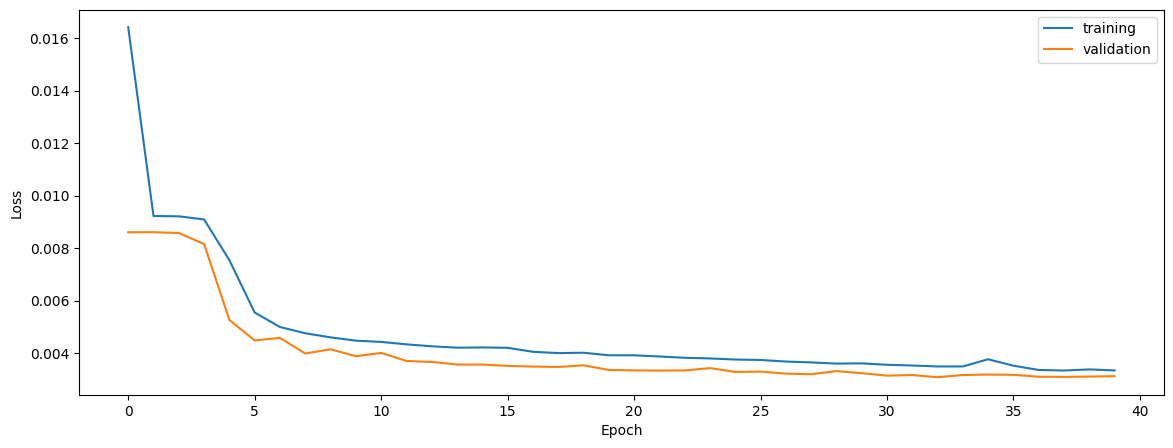

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


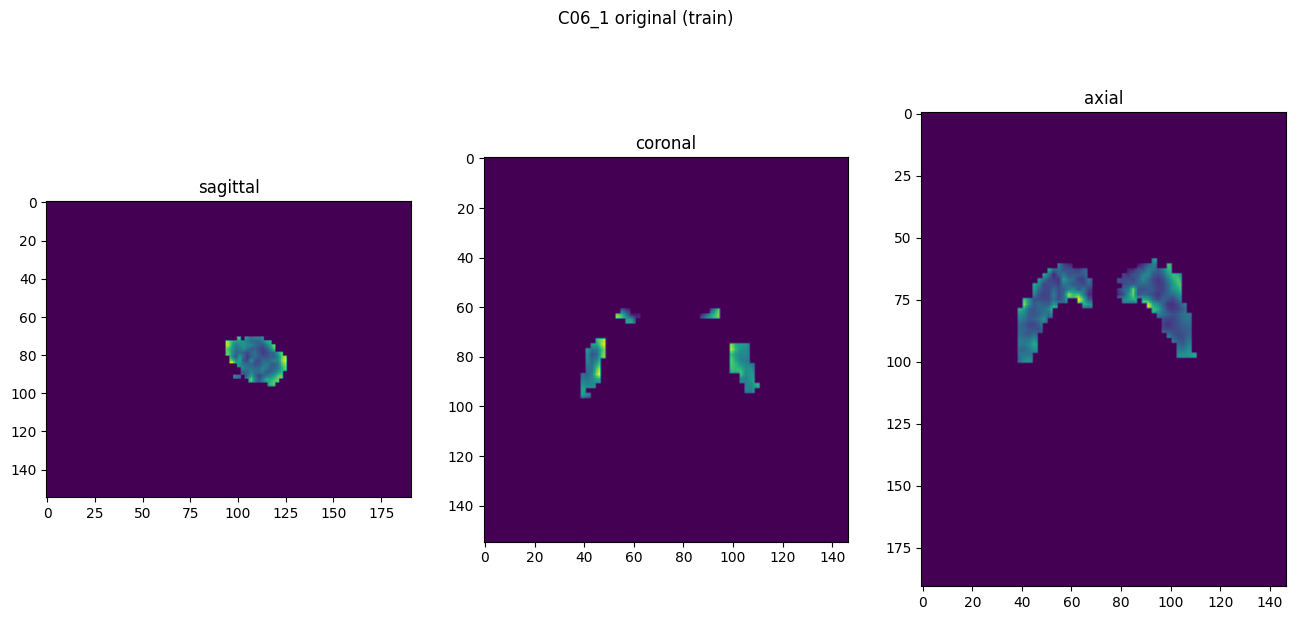

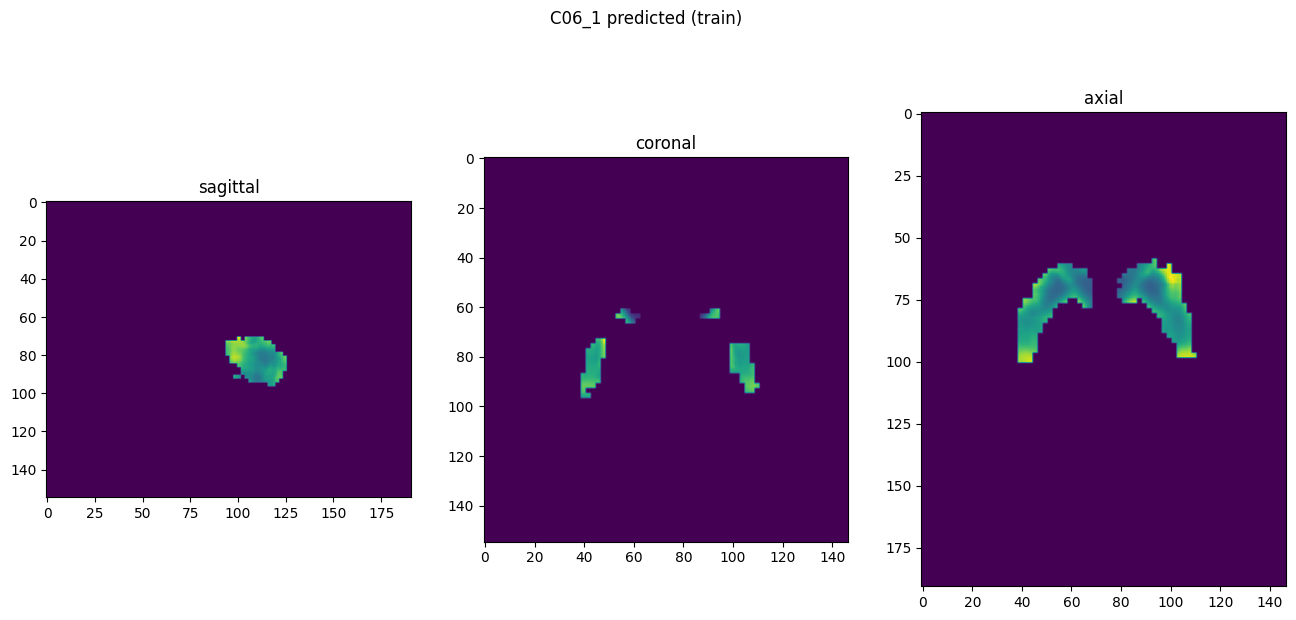

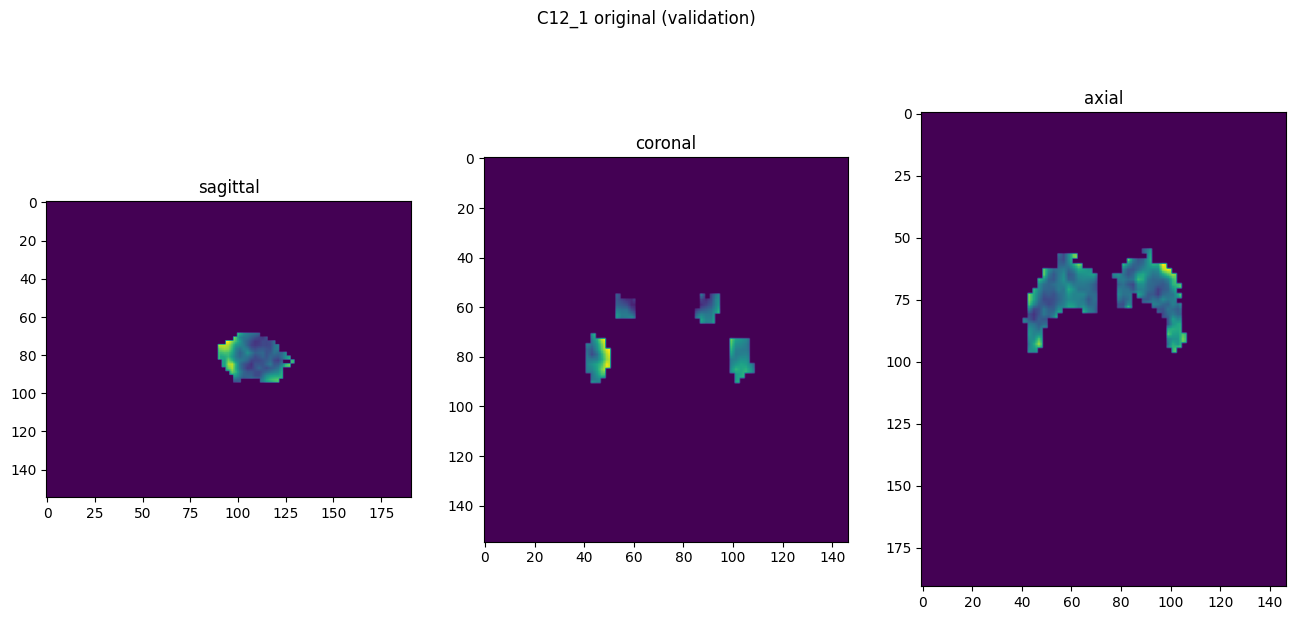

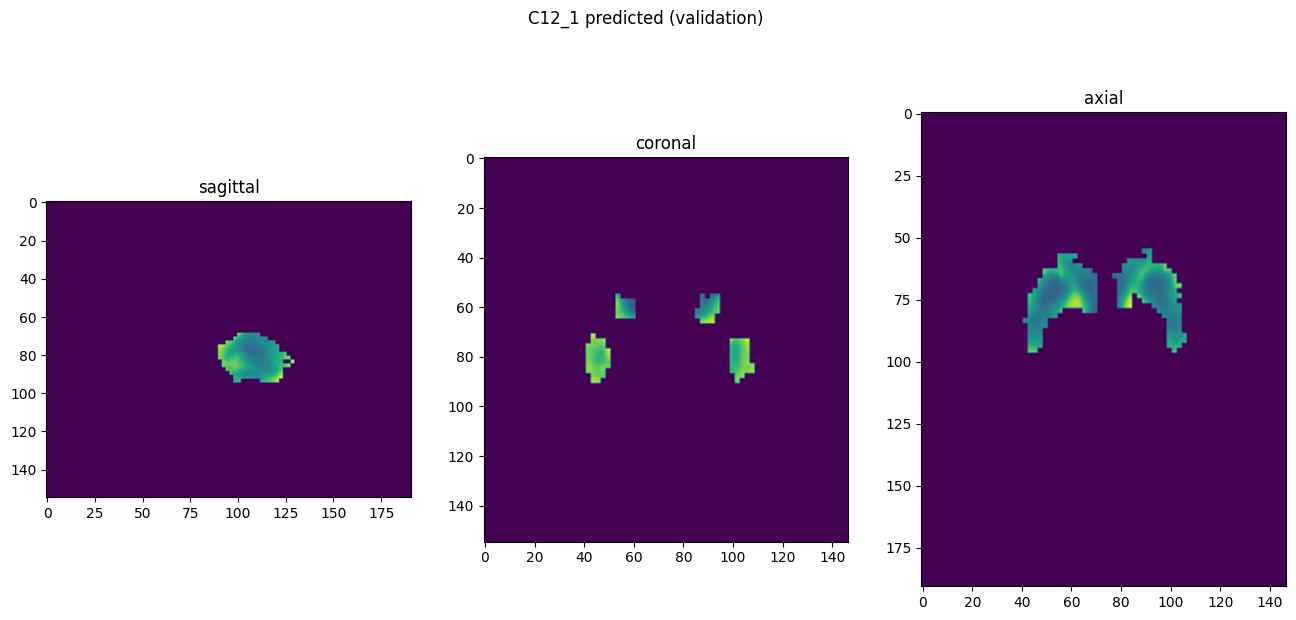

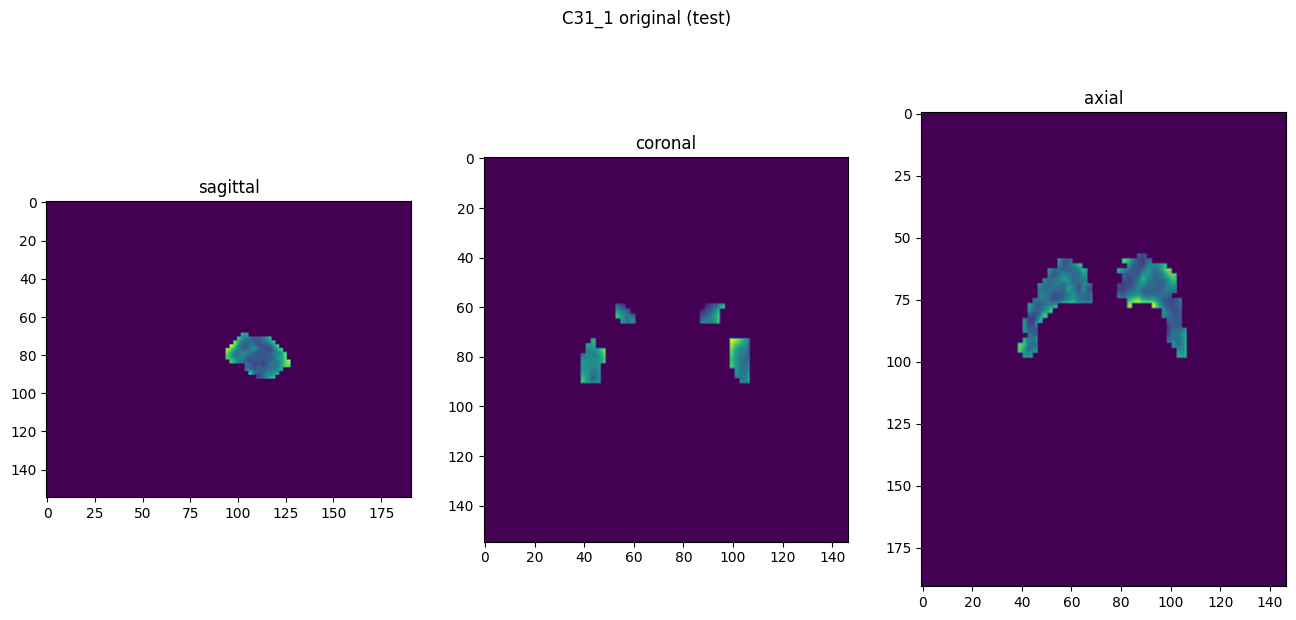

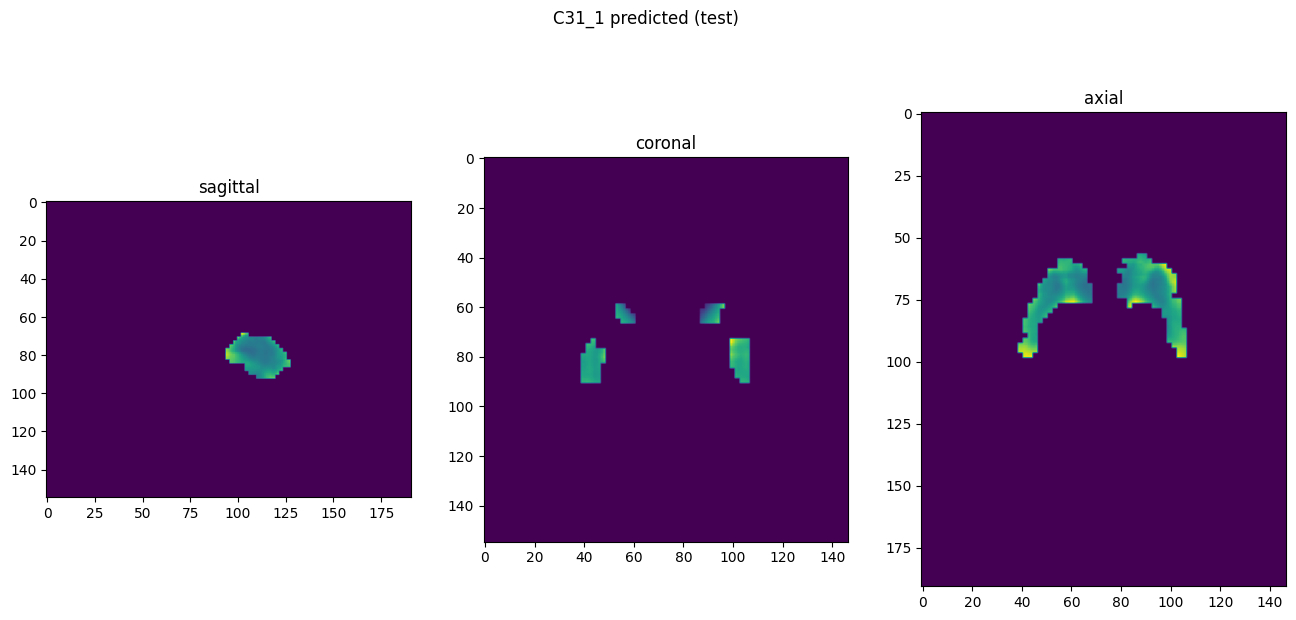

In [10]:
showResults(model, gen, threshold=None, background=False)